In [1]:
%load_ext autoreload
%autoreload 2
from functions.pytorch_functions import *
from tqdm import tqdm
import pickle

In [2]:
ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = load_data()

Full data shape: (38309, 53, 3)


In [3]:
seq_len = 49
index_start = 0
# index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all_centered[index_start:index_start+seq_len]
animation = animate_stick(xtest, 
                          figsize=(10,8), 
                          cmap='inferno', 
                          cloud=False
                         )
HTML(animation.to_html5_video())

Seeding with frame 0


# Convert to NRI format

### Start with creating the train & validation sets...

In [8]:
ds_all_centered = ds_all_centered.reshape((38309,3,53))
print(ds_all_centered.shape)

(38309, 3, 53)


In [12]:
n_simulations = 500
seq_length = 49
nodes = []
velocities = []
edges = []

start = 0
for n in range(n_simulations):
    start += seq_length+1
    sequence = ds_all_centered[start:start+seq_length]
    nodes.append(sequence)
    velocities.append(np.vstack([np.zeros((1,3,53)),np.stack([(sequence[i+1] - sequence[i])*35 for i in range(seq_length-1)])])) # first velocity is always 0, I guess
    edges.append(np.ones((53,53))) # fully-connected

nodes = np.stack(nodes)
velocities = np.stack(velocities)
edges = np.stack(edges)

In [13]:
print(nodes.shape)
print(velocities.shape)
print(edges.shape)

(500, 49, 3, 53)
(500, 49, 3, 53)
(500, 53, 53)


In [14]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [15]:
nodes, velocities, edges = unison_shuffled_copies(nodes, velocities, edges) # shuffle all of them in the same way

In [18]:
train_index = int(n_simulations*(.8)) # first 80% go to the training set; remaining 20% go to the validation set
print(train_index)

400


In [19]:
np.save("../NRI/data/loc_train_dance.npy", nodes[:train_index])
np.save("../NRI/data/vel_train_dance.npy", velocities[:train_index])
np.save("../NRI/data/edges_train_dance.npy", edges[:train_index])

np.save("../NRI/data/loc_valid_dance.npy", nodes[train_index:])
np.save("../NRI/data/vel_valid_dance.npy", velocities[train_index:])
np.save("../NRI/data/edges_valid_dance.npy", edges[train_index:])

Preview the samples you just saved:

In [21]:
nodes = np.load("../NRI/data/loc_train_dance.npy")
velocities = np.load("../NRI/data/vel_train_dance.npy")
edges = np.load("../NRI/data/edges_train_dance.npy")

animation = animate_stick(nodes[1].reshape((xtest.shape)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

### Now make the test set, with a longer sequence length (1000 timesteps), starting after timestep 49*500 = 24,500

In [24]:
(38309-24500)/1000

13.809

In [27]:
n_simulations = 12
seq_length = 1000
nodes = []
velocities = []
edges = []
start = 24500

for n in range(n_simulations):
    start += seq_length+1
    sequence = ds_all_centered[start:start+seq_length]
    nodes.append(sequence)
    velocities.append(np.vstack([np.zeros((1,3,53)),np.stack([(sequence[i+1] - sequence[i])*35 for i in range(seq_length-1)])])) # first velocity is always 0, I guess
    edges.append(np.ones((53,53))) # fully-connected

nodes = np.stack(nodes)
velocities = np.stack(velocities)
edges = np.stack(edges)

In [28]:
print(nodes.shape)
print(velocities.shape)
print(edges.shape)

(12, 1000, 3, 53)
(12, 1000, 3, 53)
(12, 53, 53)


In [29]:
np.save("../NRI/data/loc_test_dance.npy", nodes)
np.save("../NRI/data/vel_test_dance.npy", velocities)
np.save("../NRI/data/edges_test_dance.npy", edges)

Preview the test set you just saved:

In [30]:
nodes = np.load("../NRI/data/loc_test_dance.npy") 
velocities = np.load("../NRI/data/vel_test_dance.npy")
edges = np.load("../NRI/data/edges_test_dance.npy")

In [31]:
animation = animate_stick(nodes[0].reshape((1000,53,3)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

# Visualize the NRI training outputs

In [4]:
import pickle
predicted_outputs = pickle.load(open("../NRI/logs/dance_short_test/predicted_outputs.txt", "rb"))
actual_outputs = pickle.load(open("../NRI/logs/dance_short_test/actual_outputs.txt", "rb"))

actual = actual_outputs[0][0,:,:,:3]
actual = np.transpose(actual, [1, 2, 0])

pred = predicted_outputs[0][0,:,:,:3]
pred = np.transpose(pred, [1, 2, 0])

actual = actual.reshape((20,53,3))
pred = pred.reshape((20,53,3))

In [5]:
animation = animate_stick(actual, 
                          ghost=pred, 
                          figsize=(10,8), cmap='inferno')
HTML(animation.to_html5_video())

# Misc

In [22]:
test_data_loader= pickle.load(open("../NRI/logs/dance_short_test/test_data_loader.txt", "rb"))

In [45]:
test_data = test_data_loader.data.numpy()
test = test_data[0,:,:100,:3]
test.shape

(53, 100, 3)

Text(0.5, 0.92, 'Sequence 0')

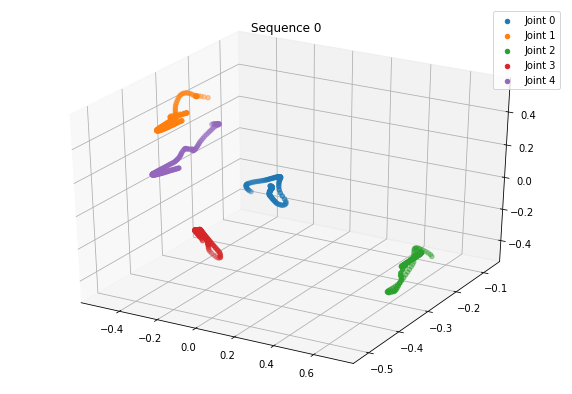

In [46]:
fig = plt.figure(figsize=(10,7))

joints = np.arange(5)


### Sequence 0
seq_number = 0
ax = fig.add_subplot(1,1,1, projection='3d')
for i in joints:
    ax.scatter(test[i,:,0],test[i,:,1],test[i,:,2], marker='o', 
#                label=joint_names[i]
               label="Joint "+str(i)
              )
ax.legend()
ax.set_title("Sequence {}".format(seq_number))



In [76]:
train_data_loader= pickle.load(open("../NRI/logs/dance_short_test/train_data_loader.txt", "rb"))
train_data = train_data_loader.data.numpy()
train = train_data
train.shape

(1, 53, 49, 6)

In [79]:
animation = animate_stick(train.reshape((xtest.shape)),figsize=(10,8), cmap='inferno')
HTML(animation.to_html5_video())

# Okay where is the issue?

In [44]:
loc_train = np.load("../NRI/data/loc_train_dance_short.npy")
loc_train.shape

(16, 49, 3, 53)

In [49]:
animation = animate_stick(loc_train[0].reshape((xtest.shape)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

In [51]:
loc_train_normalized = pickle.load(open("../NRI/logs/dance_short_test/loc_train_normalized.txt", "rb"))
loc_train_normalized.shape

(16, 49, 3, 53)

In [52]:
animation = animate_stick(loc_train_normalized[0].reshape((xtest.shape)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

In [61]:
loc_train_transposed = pickle.load(open("../NRI/logs/dance_short_test/loc_train_transposed.txt", "rb"))
loc_train_transposed.shape

(16, 53, 49, 3)

In [62]:
loc_train_transposed = np.transpose(loc_train_transposed, [0, 2, 3, 1])
loc_train_transposed.shape

(16, 49, 3, 53)

In [66]:
loc_train_transposed[0].shape

(49, 3, 53)

In [65]:
animation = animate_stick(loc_train_transposed[0].reshape((xtest.shape)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

In [72]:
feat_train = pickle.load(open("../NRI/logs/dance_short_test/feat_train.txt", "rb"))
feat_train.shape

(16, 53, 49, 6)

In [73]:
feat_train = feat_train[0,:,:,:3]
feat_train = np.transpose(feat_train, [1, 2, 0])
feat_train.shape

(49, 3, 53)

In [74]:
animation = animate_stick(feat_train.reshape((xtest.shape)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

# 3D projectile plot

Text(0.5, 0.92, 'Sequence 0')

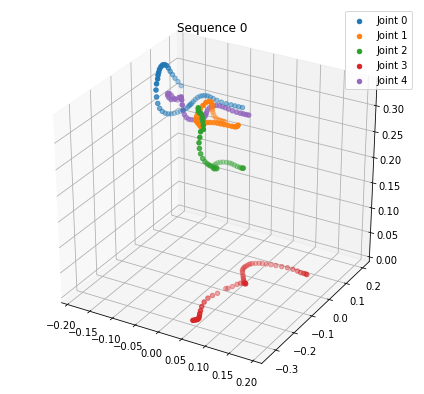

In [8]:
fig = plt.figure(figsize=(25,7))
# ax = p3.Axes3D(fig)

joints = np.arange(5)

### Sequence 0
seq_number = 0
ax = fig.add_subplot(1,3,1, projection='3d')
for i in joints:
    ax.scatter(xtest[:,i,0],xtest[:,i,1],xtest[:,i,2], marker='o', 
#                label=joint_names[i]
               label="Joint "+str(i)
              )
ax.legend()
ax.set_title("Sequence {}".format(seq_number))


# ### Sequence 1
# seq_number = 1
# ax = fig.add_subplot(1,3,2, projection='3d')
# for i in joints:
#     ax.scatter(nodes[seq_number, :, 0, i],nodes[seq_number, :, 1, i],nodes[seq_number, :, 2, i], marker='o', 
# #                label=joint_names[i]
#                label="Joint "+str(i)
#               )
# ax.legend()
# ax.set_title("Sequence {}".format(seq_number))


# ### Sequence 2
# seq_number = 2
# ax = fig.add_subplot(1,3,3, projection='3d')
# for i in joints:
#     ax.scatter(nodes[seq_number, :, 0, i],nodes[seq_number, :, 1, i],nodes[seq_number, :, 2, i], marker='o', 
# #                label=joint_names[i]
#                label="Joint "+str(i)
#               )
# ax.legend()
# ax.set_title("Sequence {}".format(seq_number))

